In [ ]:
import torch
from torch import nn
import numpy as np
from torchvision.utils import save_image

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Dataset

In [ ]:
import torchvision

img_size = 32
num_classes = 10

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist_images = torchvision.datasets.MNIST(root='./mnist_data', train=True,
                                    download=True, transform=transform)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
dataloader = DataLoader(mnist_images, batch_size=BATCH_SIZE, shuffle=True)

# 2. Model

In [ ]:
channels = 1
img_shape = (channels, img_size, img_size)
latent_dim = 100

In [ ]:
class Generator(nn.Module):
   def __init__(self, num_classes, emb_dim):
    super().__init__()
    self.label_emb = nn.Embedding(num_classes, emb_dim)
    self.model = nn.Sequential(
        nn.Linear(latent_dim + emb_dim, 256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(512, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(1024, int(np.prod(img_shape))),
        nn.Tanh()
    )
   def forward(self, z, label):
    cond = self.label_emb(label)
    x = torch.cat([z, cond], 1)
    img = self.model(x)
    img = img.view(img.size(0), *img_shape)
    return img

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, num_classes, emb_dim):
    super().__init__()
    self.label_emb = nn.Embedding(num_classes, emb_dim)

    self.model = nn.Sequential(
        nn.Linear(int(np.prod(img_shape)) + emb_dim, 512),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(256, 1),
        nn.Sigmoid()
    )
  def forward(self, img, label):
    img_flat = img.view(img.size(0), -1)
    cond = self.label_emb(label)
    x = torch.cat([img_flat, cond], 1)
    validity = self.model(x)
    return validity

In [ ]:
generator = Generator(num_classes, emb_dim=16)
discriminator = Discriminator(num_classes, emb_dim=16)

In [ ]:
generator.to(device)

Generator(
  (label_emb): Embedding(10, 16)
  (model): Sequential(
    (0): Linear(in_features=116, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): Tanh()
  )
)

In [ ]:
discriminator.to(device)

Discriminator(
  (label_emb): Embedding(10, 16)
  (model): Sequential(
    (0): Linear(in_features=1040, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# 3. Training

In [ ]:
import os
os.makedirs('cGAN_images', exist_ok=True)

save_interval = 10

In [ ]:
EPOCHS = 100

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

hist = {
    'train_G_loss': [],
    'train_D_loss': []
}

In [ ]:
for epoch in range(EPOCHS):
  running_G_loss = 0.0
  running_D_loss = 0.0

  for i, (imgs, labels) in enumerate(dataloader):
    real_imgs = imgs.to(device)
    labels = labels.to(device)

    real_labels = torch.ones((imgs.shape[0],1)).to(device)
    fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)

    # ----- Train Generator -------
    optimizer_G.zero_grad()

    # Noise input for generator
    z = torch.randn((imgs.shape[0], latent_dim)).to(device)

    gen_imgs = generator(z, labels)
    G_loss = criterion(discriminator(gen_imgs, labels), real_labels)
    running_G_loss += G_loss.item()

    G_loss.backward()
    optimizer_G.step()

    # ------ Train Discriminator -----
    optimizer_D.zero_grad()

    real_loss = criterion(discriminator(real_imgs, labels), real_labels)
    fake_loss = criterion(discriminator(gen_imgs.detach(), labels), fake_labels)

    D_loss = (real_loss + fake_loss)/2
    running_D_loss += D_loss.item()

    D_loss.backward()
    optimizer_D.step()

  epoch_G_loss = running_G_loss / len(dataloader)
  epoch_D_loss = running_D_loss / len(dataloader)

  print(f'Epoch {epoch+1}/{EPOCHS}, Train G Loss: {epoch_G_loss:.4f}, Train D Loss: {epoch_D_loss: .4f}')

  hist['train_D_loss'].append(epoch_D_loss)
  hist['train_G_loss'].append(epoch_G_loss)

  if epoch % save_interval == 0:
    save_image(gen_imgs.data[:25], f"cGAN_images/epoch_{epoch}.png", nrow=5, normalize=True)

Epoch 1/100, Train G Loss: 11.9443, Train D Loss:  0.0544
Epoch 2/100, Train G Loss: 15.7255, Train D Loss:  0.0638
Epoch 3/100, Train G Loss: 15.2762, Train D Loss:  0.0813
Epoch 4/100, Train G Loss: 14.6809, Train D Loss:  0.1007
Epoch 5/100, Train G Loss: 14.1166, Train D Loss:  0.1254
Epoch 6/100, Train G Loss: 14.0668, Train D Loss:  0.1604
Epoch 7/100, Train G Loss: 13.8492, Train D Loss:  0.1420
Epoch 8/100, Train G Loss: 13.8089, Train D Loss:  0.1794
Epoch 9/100, Train G Loss: 13.6515, Train D Loss:  0.1459
Epoch 10/100, Train G Loss: 13.7152, Train D Loss:  0.1506
Epoch 11/100, Train G Loss: 10.6262, Train D Loss:  0.1829
Epoch 12/100, Train G Loss: 3.8162, Train D Loss:  0.1886
Epoch 13/100, Train G Loss: 3.5366, Train D Loss:  0.2073
Epoch 14/100, Train G Loss: 3.6437, Train D Loss:  0.1704
Epoch 15/100, Train G Loss: 3.5971, Train D Loss:  0.1956
Epoch 16/100, Train G Loss: 3.4649, Train D Loss:  0.1890
Epoch 17/100, Train G Loss: 3.4495, Train D Loss:  0.1914
Epoch 18/100

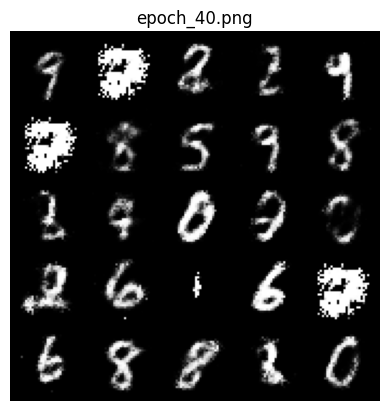

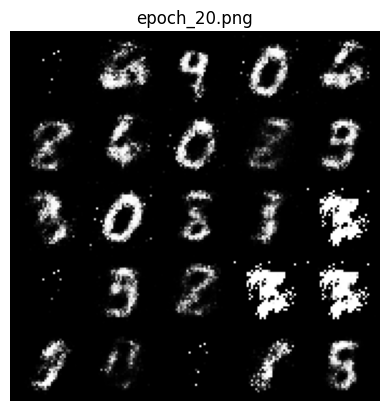

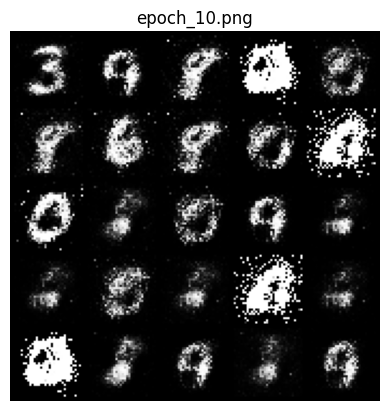

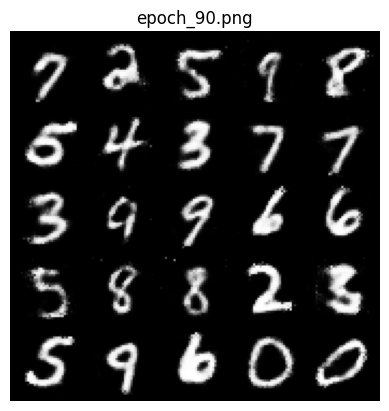

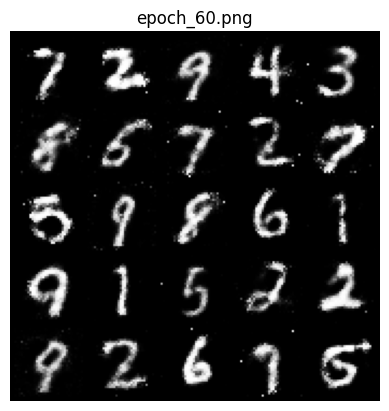

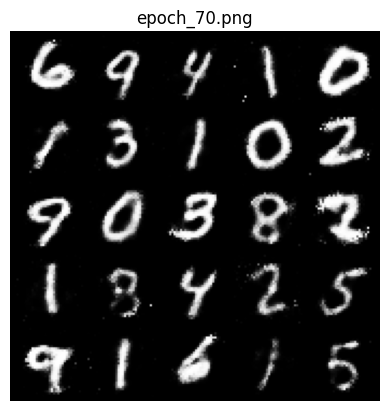

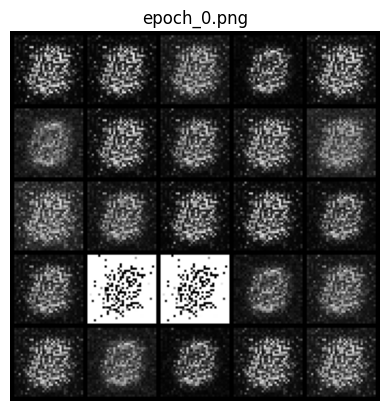

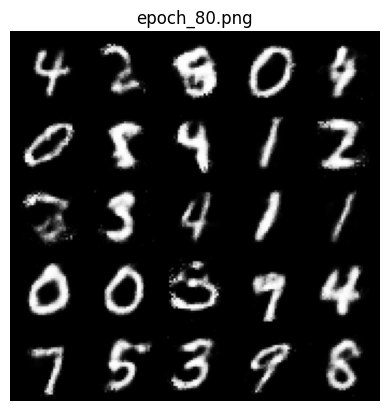

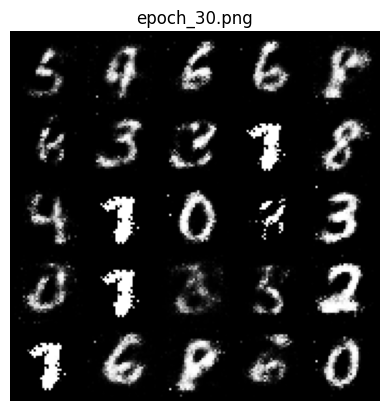

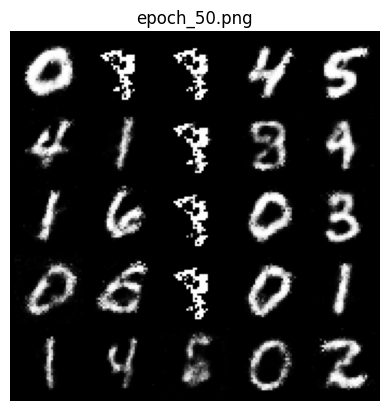

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to your image folder
folder_path = '/content/cGAN_images'

# Get list of all files in the folder
images = os.listdir(folder_path)

# Create subplots based on number of images

# Iterate and plot each image
for i, image_name in enumerate(images):
    # Construct full image path
    image_path = os.path.join(folder_path, image_name)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_name)
    plt.show()



# 4. Inference

In [ ]:
%matplotlib inline
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
generator.eval()

num_sample = 5
for i in range(num_classes):
    target_class = i
    z = torch.randn((num_sample, letent_dim)).to(device)
    condition_labels = torch.full((num_sample,), target_class, dtype=torch.long).to(device)

    gen_imgs = generator(z, conditional_labels).detach().cpu()

    grid = make_grid(gen_imgs, nrow=num_sampple, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()